## Prepare the dataset

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

pd.pandas.set_option('display.max_columns', None)
RANDOM_STATE = 0

In [3]:
try:
    data = pd.read_csv('data/titanic.csv')
except:
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data.to_csv('../data/titanic.csv', index=False)

In [4]:
print(data.shape)
data.head()

(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [5]:
data = data.replace('?', np.nan)

In [6]:
data.name.apply(
    lambda s: list(map(lambda s: s.strip(), s.split(',')))[1].split()[0]
).value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Dr.            8
Rev.           8
Col.           4
Mlle.          2
Major.         2
Ms.            2
Mme.           1
Sir.           1
Capt.          1
the            1
Jonkheer.      1
Lady.          1
Dona.          1
Don.           1
Name: name, dtype: int64

In [7]:
# retain only the first cabin if more than 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [8]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [9]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [10]:
# drop unnecessary variables
data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [11]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

## Data exploration

### Find numerical and categorical variables

In [12]:
target = 'survived'

In [13]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O'] + ['pclass']
num_vars = [var for var in data.columns if var not in cat_vars and var != 'survived']

In [14]:
print(f'Number of numerical variables: {cat_vars}')
print(f'Number of categorical variables: {num_vars}')

Number of numerical variables: ['sex', 'cabin', 'embarked', 'title', 'pclass']
Number of categorical variables: ['age', 'sibsp', 'parch', 'fare']


### Find missing values in variables

In [15]:
cat_vars_with_na = [var for var in cat_vars if data[var].isnull().sum() > 0]
num_vars_with_na = [var for var in num_vars if data[var].isnull().sum() > 0]

### Determine cardinality of categorical variables

In [16]:
for var in cat_vars:
    print(data[var].value_counts())
    print()

male      843
female    466
Name: sex, dtype: int64

F       8
C23     6
G6      5
B57     5
F4      4
       ..
E38     1
D34     1
E77     1
B102    1
C47     1
Name: cabin, Length: 181, dtype: int64

S    914
C    270
Q    123
Name: embarked, dtype: int64

Mr        758
Miss      258
Mrs       201
Master     61
Other      31
Name: title, dtype: int64

3    709
1    323
2    277
Name: pclass, dtype: int64



### Determine the distribution of numerical variables

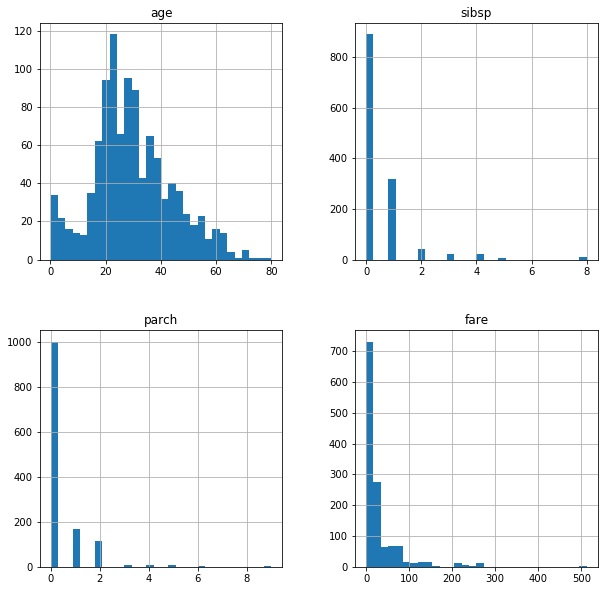

In [17]:
data[num_vars].hist(bins=30, figsize=(10, 10));

## Train test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),      # predictors
    data['survived'],                   # target
    test_size=0.2,  
    random_state=RANDOM_STATE) 

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature engineering

### Extract letter from cabin

In [19]:
X_train['cabin'] = X_train['cabin'].fillna('M')
X_train['cabin'] = X_train['cabin'].apply(lambda s: s[0])

X_test['cabin'] = X_test['cabin'].fillna('M')
X_test['cabin'] = X_test['cabin'].apply(lambda s: s[0])

### Missing value imputation for numerical variables

In [20]:
for var in num_vars_with_na:
    median = X_train[var].median()
    X_train[var].fillna(median, inplace=True)
    X_test[var].fillna(median, inplace=True)

### Missing category for categorical variables

In [21]:
for var in cat_vars_with_na:
    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)

### Rare labels in cat vars

In [22]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [23]:
for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.05)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index([], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')

pclass Int64Index([1, 2, 3], dtype='int64', name='pclass')



### One-hot encoding into k-1 binary vars

In [24]:
for var in cat_vars:
    for cat in X_train[var].unique()[:-1]:
        X_train[f'{var}={cat}'] = np.where(X_train[var]==cat, 1, 0)
        X_test[f'{var}={cat}'] = np.where(X_test[var]==cat, 1, 0)
    
    X_train.drop(var, axis=1, inplace=True)
    X_test.drop(var, axis=1, inplace=True)

### Scale the variables

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train logistic regression model

In [26]:
model = LogisticRegression(C=0.0005)
model.fit(X_train, y_train)

LogisticRegression(C=0.0005)

## Make preds and evaluate model performance

* ROC-AUC
* Accuracy

In [27]:
print(f'Train ROC-AUC: \t{roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}')
print(f'Test ROC-AUC: \t{roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}')

Train ROC-AUC: 	0.8404887944358579
Test ROC-AUC: 	0.8428703703703704


In [28]:
print(f'Train accuracy: \t{accuracy_score(y_train, model.predict(X_train))}')
print(f'Test accuracy: \t{accuracy_score(y_test, model.predict(X_test))}')

Train accuracy: 	0.7067812798471824
Test accuracy: 	0.7061068702290076
